In [1]:
import six

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import six

sns.set(style='ticks', context='paper', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline


folder = 'figures'
!mkdir $folder
import flotilla
flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects'

study = flotilla.embark('singlecell_pnm_figure2_modalities_bayesian', flotilla_dir=flotilla_dir)
not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)

psi = study.splicing.singles.ix[not_outliers]
grouped = psi.groupby(study.sample_id_to_phenotype)
psi_filtered = grouped.apply(lambda x: x.dropna(axis=1, thresh=20))

mkdir: cannot create directory `figures': File exists


/home/obotvinnik/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:810: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/obotvinnik/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())
/home/obotvinnik/anaconda/lib/python2.7/site-packages/flotilla/__init__.py:55: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  load_species_data=load_species_data)


2016-05-15 19:15:11	Reading datapackage from /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure2_modalities_bayesian/datapackage.json
2016-05-15 19:15:11	Parsing datapackage to create a Study object
2016-05-15 19:15:47	Initializing Study
2016-05-15 19:15:47	Initializing Predictor configuration manager for Study
2016-05-15 19:15:47	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-05-15 19:15:47	Added ExtraTreesClassifier to default predictors
2016-05-15 19:15:47	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-05-15 19:15:47	Added ExtraTreesRegressor to default predictors
2016-05-15 19:15:47	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-05-15 19:15:47	Added GradientBoostingClassifier to default predictors
2016-05-15 19:15:47	Predictor GradientBoostingRegressor is of type <class 'sklearn.

In [2]:
figure_folder = '{}/intron_conservation'.format(folder)
! mkdir $figure_folder

In [3]:
ls /projects/ps-yeolab/obotvinnik/singlecell_pnms/exon2*csv

ls: cannot access /projects/ps-yeolab/obotvinnik/singlecell_pnms/exon2*csv: No such file or directory


In [4]:
csv_folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms/csvs_for_paper'

In [5]:
splicing_feature_folder = '{}/splicing_feature_data'.format(csv_folder)
alternative_feature_folder = '{}/alternative'.format(splicing_feature_folder)
constitutive_feature_folder = '{}/constitutive'.format(splicing_feature_folder)

In [6]:
alternative_feature_folder

'/projects/ps-yeolab/obotvinnik/singlecell_pnms/csvs_for_paper/splicing_feature_data/alternative'

In [7]:
downstream = pd.read_csv('{}/downstream400_placental_mammal_conservation.csv'.format(alternative_feature_folder), 
                         index_col=0)
upstream = pd.read_csv('{}/upstream400_placental_mammal_conservation.csv'.format(alternative_feature_folder), 
                       index_col=0)

In [8]:
conservation_folder = '{}/conservation'.format(folder)

In [9]:
from anchor import MODALITY_ORDER, MODALITY_PALETTE

In [10]:
sns.set(style='ticks', context='paper')

In [11]:
from anchor import MODALITY_ORDER

In [12]:
constitutive_downstream = pd.read_csv('{}/downstream400_placental_mammal_conservation.csv'.format(constitutive_feature_folder), 
                         index_col=0)
constitutive_upstream = pd.read_csv('{}/upstream400_placental_mammal_conservation.csv'.format(constitutive_feature_folder), 
                       index_col=0)

In [13]:
constitutive_conservations = {'Upstream': constitutive_upstream, 'Downstream': constitutive_downstream}

In [14]:
from scipy.stats import mannwhitneyu

In [15]:
# %%time

intron_conservations = {'Upstream': upstream, 
                        'Downstream': downstream}

modality_basewise_conservation_dfs = []

intron_order = ['Upstream', 'Downstream']

values_col = r'$\mathrm{sgn}(\Delta\mathrm{mean}) \times\left(-\log_{10}(q)\right)$'


phenotype_basewise_statistics_dfs = []

for phenotype, phenotype_df in study.supplemental.modalities_tidy.groupby('phenotype'):
    modalities = phenotype_df.set_index('event_id').modality
    modalities = modalities.drop(modalities.index.get_duplicates())
    
    conservation_dfs = []
    basewise_statistics_dfs = []
    

    for intron_name, intron_conservation in intron_conservations.items():
        mean_conservation = intron_conservation.groupby(modalities).mean()
        mean_conservation.columns = mean_conservation.columns.astype(int) + 1
        tidy = mean_conservation.unstack().reset_index()
        tidy = tidy.rename(columns={'level_0':'genome_direction_nt', 0: 'Conservation'})
        tidy['direction'] = intron_name
        conservation_dfs.append(tidy)
        conservation_grouped = intron_conservation.groupby(modalities)
#         constitutive_name = '~1'

#         constitutive = conservation_grouped.get_group(constitutive_name)
        constitutive = constitutive_conservations[intron_name]
    
        constitutive_mean = constitutive.mean()
        constitutive_mean.index = constitutive_mean.index.astype(int) + 1
        tidy = constitutive_mean.reset_index()
        tidy['modality'] = 'constitutive'
        tidy['direction'] = intron_name
        tidy = tidy.rename(columns={'index':'genome_direction_nt', 0: 'Conservation'})
        conservation_dfs.append(tidy)
        
        for modality, df in conservation_grouped:
#             if modality == constitutive_name:
#                 continue
            lines = []

            for i in df:
                statistic, p_value = mannwhitneyu(df[i], constitutive[i])
                sign = np.sign(df[i].mean() - constitutive[i].mean())
                lines.append([statistic, p_value, sign])
            intron_basewise_statistics = pd.DataFrame(lines, columns=['U Statistic', '$p$-value', 'sign'])
            intron_basewise_statistics['$q$-value'] = intron_basewise_statistics.shape[0] * intron_basewise_statistics['$p$-value']
            intron_basewise_statistics['modality'] = modality
            intron_basewise_statistics['intron'] = intron_name
            intron_basewise_statistics = intron_basewise_statistics.reset_index()
            intron_basewise_statistics = intron_basewise_statistics.rename(columns={'index': 'genome_direction_nt'})
#             print '\n', phenotype, intron_name, modality
#             print intron_basewise_statistics.groupby('genome_direction_nt').size().head()
            basewise_statistics_dfs.append(intron_basewise_statistics)

    basewise_statistics = pd.concat(basewise_statistics_dfs, ignore_index=True)
    basewise_statistics['$-\log_{10}(q)$'] = -np.log10(basewise_statistics['$q$-value'])
    basewise_statistics['$-\log_{10}(p)$'] = -np.log10(basewise_statistics['$p$-value'])

    basewise_statistics[values_col] = basewise_statistics['sign'] * basewise_statistics['$-\log_{10}(q)$']
    basewise_statistics['phenotype'] = phenotype
#     print basewise_statistics.groupby(['modality', 'intron', 'genome_direction_nt']).size().head()
#     print 'basewise_statistics.shape', basewise_statistics.shape
    phenotype_basewise_statistics_dfs.append(basewise_statistics)
#     basewise_statistics.head()

#         var_conservation = intron_conservation.groupby(modalities).var()
    modality_basewise_conservation = pd.concat(conservation_dfs, ignore_index=True)
    modality_basewise_conservation['phenotype'] = phenotype
    modality_basewise_conservation_dfs.append(modality_basewise_conservation)

modality_basewise_conservation = pd.concat(modality_basewise_conservation_dfs, ignore_index=True)
six.print_(modality_basewise_conservation.shape)
modality_basewise_statistics = pd.concat(phenotype_basewise_statistics_dfs, ignore_index=True)
six.print_(modality_basewise_statistics.shape)
modality_basewise_statistics.head()

(12800, 5)
(10400, 11)


,genome_direction_nt,U Statistic,$p$-value,sign,$q$-value,modality,intron,$-\log_{10}(q)$,$-\log_{10}(p)$,$\mathrm{sgn}(\Delta\mathrm{mean}) \times\left(-\log_{10}(q)\right)$,phenotype
0,0,3494411.0,1.786188e-08,-1,0.000007,bimodal,Downstream,5.146013,7.748073,-5.146013,MN
1,1,3593197.5,2.864930e-05,-1,0.011460,bimodal,Downstream,1.940826,4.542886,-1.940826,MN
2,2,3756166.0,7.380786e-02,-1,29.523142,bimodal,Downstream,-1.470163,1.131897,1.470163,MN
3,3,3881496.0,9.542460e-01,-1,381.698401,bimodal,Downstream,-2.581720,0.020340,2.581720,MN
4,4,3975242.5,1.524522e-01,-1,60.980880,bimodal,Downstream,-1.785194,0.816866,1.785194,MN


### Compare intron modality conservation vs same modality in iPSC

In [16]:
phenotype_grouped = study.supplemental.modalities_tidy.groupby('phenotype')
ipsc = phenotype_grouped.get_group('iPSC')
ipsc_modalities = ipsc.groupby('modality')

lines = []

for intron_name, intron_conservation in intron_conservations.items():
#     six.print_(intron_name)
    for phenotype in study.phenotype_order[1:]:
#         six.print_('\t', phenotype)
        phenotype_df = phenotype_grouped.get_group(phenotype)
        for modality, modality_df in phenotype_df.groupby('modality'):
#             six.print_('\t\t', modality)
            ipsc = ipsc_modalities.get_group(modality)
            ipsc_conservation = intron_conservation.loc[ipsc['event_id']].mean(axis=1)
            try:
                phenotype_conservation = intron_conservation.loc[modality_df['event_id']].mean(axis=1)
            except KeyError:
                continue
            
            statistic, p_value = mannwhitneyu(ipsc_conservation, phenotype_conservation)
#             six.print_('\t\t\t', statistic, p_value)
            lines.append([phenotype, intron_name, modality, statistic, p_value])
intron_conservation_vs_ipsc = pd.DataFrame(lines, columns=['phenotype', 'intron', 'modality', 'U_statistic', 'p-value'])
intron_conservation_vs_ipsc

,phenotype,intron,modality,U_statistic,p-value
0,NPC,Downstream,bimodal,3970737.5,0.672870
1,NPC,Downstream,excluded,2042950.0,0.114340
2,NPC,Downstream,included,13945300.5,0.581614
3,NPC,Downstream,uncategorized,90.5,0.287609
4,MN,Downstream,bimodal,2136245.5,0.002716
5,MN,Downstream,excluded,1336795.0,0.709101
6,MN,Downstream,included,8923063.5,0.061995
7,MN,Downstream,uncategorized,11.0,0.116217
8,NPC,Upstream,bimodal,3969155.5,0.654184
9,NPC,Upstream,excluded,2024710.5,0.282089


In [17]:
intron_conservation_vs_ipsc['q-value'] = intron_conservation_vs_ipsc['p-value'] * intron_conservation_vs_ipsc.shape[0]
intron_conservation_vs_ipsc

,phenotype,intron,modality,U_statistic,p-value,q-value
0,NPC,Downstream,bimodal,3970737.5,0.672870,10.765915
1,NPC,Downstream,excluded,2042950.0,0.114340,1.829444
2,NPC,Downstream,included,13945300.5,0.581614,9.305821
3,NPC,Downstream,uncategorized,90.5,0.287609,4.601741
4,MN,Downstream,bimodal,2136245.5,0.002716,0.043464
5,MN,Downstream,excluded,1336795.0,0.709101,11.345615
6,MN,Downstream,included,8923063.5,0.061995,0.991914
7,MN,Downstream,uncategorized,11.0,0.116217,1.859465
8,NPC,Upstream,bimodal,3969155.5,0.654184,10.466944
9,NPC,Upstream,excluded,2024710.5,0.282089,4.513427


In [18]:
intron_conservation_vs_ipsc.loc[intron_conservation_vs_ipsc['p-value'] < 0.1]

,phenotype,intron,modality,U_statistic,p-value,q-value
4,MN,Downstream,bimodal,2136245.5,0.002716,0.043464
6,MN,Downstream,included,8923063.5,0.061995,0.991914
12,MN,Upstream,bimodal,2113659.0,0.000407,0.006508
14,MN,Upstream,included,8948862.0,0.099630,1.594075


In [19]:
intron_conservation_vs_ipsc.loc[intron_conservation_vs_ipsc['q-value'] < 0.1]

,phenotype,intron,modality,U_statistic,p-value,q-value
4,MN,Downstream,bimodal,2136245.5,0.002716,0.043464
12,MN,Upstream,bimodal,2113659.0,0.000407,0.006508


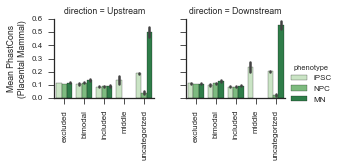

In [20]:
g = sns.factorplot(col='direction', y='Conservation', hue='phenotype', size=2, col_order=intron_order,
               x='modality', data=modality_basewise_conservation, kind='bar', order=MODALITY_ORDER,
               hue_order=study.phenotype_order, palette=study.phenotype_color_ordered, )
g.set_ylabels('Mean PhastCons\n(Placental Mammal)')
g.set(xlabel='')
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)
# g.fig.tight_layout()
g.savefig('{}/intron_mean_conservation.pdf'.format(figure_folder))

In [21]:
modality_order = ['constitutive'] + MODALITY_ORDER[:3] 
modality_palette = ['k'] + MODALITY_PALETTE[:3]

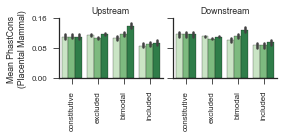

In [22]:
g = sns.factorplot(col='direction', y='Conservation', hue='phenotype', size=2, col_order=intron_order,
               x='modality', data=modality_basewise_conservation, kind='bar', order=modality_order,
               hue_order=study.phenotype_order, palette=study.phenotype_color_ordered, legend=False)
g.set_ylabels('Mean PhastCons\n(Placental Mammal)')
g.set(xlabel='')
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)
#     if ax.is_first_col():
    ax.set(yticks=[0, 0.08, 0.16], ylim=(0, 0.16))
g.fig.tight_layout()
g.set_titles('{col_name}')
g.savefig('{}/intron_mean_conservation_excluded_bimodal_included.pdf'.format(figure_folder))

## Plot basewise conservation

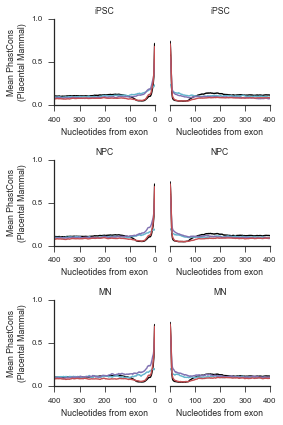

In [23]:
g = sns.FacetGrid(modality_basewise_conservation, hue='modality', hue_order=modality_order,
                 palette=modality_palette, row='phenotype', row_order=study.phenotype_order,
                  col='direction', sharex=False, #gridspec_kws=dict(wspace=0.1), #legend=False,
                  col_order=intron_order, size=2)
g.map(plt.plot, 'genome_direction_nt', 'Conservation')
for ax in g.axes.flat:
    ax.locator_params(nbins=4)
#         ax.locator_params('y', nbins=4)
    if ax.is_first_col():
        ax.set(ylabel='Mean PhastCons\n(Placental Mammal)',
               xticklabels=list(reversed([int(x) for x in ax.get_xticks()])))
    else:
        sns.despine(ax=ax, left=True)
        ax.yaxis.set_ticks_position('none')
g.set_titles('{row_name}')
g.set(xlabel='Nucleotides from exon', ylim=(0, 1))
# g.add_legend();
g.fig.subplots_adjust(wspace=0.01)
g.fig.tight_layout()
g.savefig('{}/intron_basewise_conservation_400nt.pdf'.format(figure_folder))

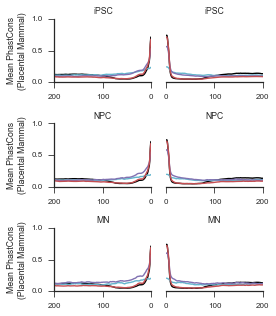

In [24]:
g = sns.FacetGrid(modality_basewise_conservation, hue='modality', hue_order=modality_order,
                 palette=modality_palette, row='phenotype', row_order=study.phenotype_order,
                  col='direction', sharex=False, #gridspec_kws=dict(wspace=0.2), #legend=False,
                  col_order=intron_order, size=1.5, aspect=1.3)
g.map(plt.plot, 'genome_direction_nt', 'Conservation')
for ax in g.axes.flat:
    ax.locator_params(nbins=4)
#         ax.locator_params('y', nbins=4)
    if ax.is_first_col():
        xticklabels = ax.get_xticks()
        ax.set(xlim=(200, 400))
        ax.set(ylabel='Mean PhastCons\n(Placental Mammal)',
               xticklabels=[200, 100, 0], xticks=(200, 300, 400))
    else:
        sns.despine(ax=ax, left=True)
        ax.yaxis.set_ticks_position('none')
        ax.set(xlim=(0, 200), xticklabels=[0, 100, 200], xticks=[0, 100, 200])
g.set_titles('{row_name}')
g.set(xlabel='', ylim=(0, 1))
# g.add_legend();
g.fig.subplots_adjust(wspace=0.01)
g.fig.tight_layout()
g.savefig('{}/intron_basewise_conservation_200nt.pdf'.format(figure_folder))

In [25]:
# import matplotlib as mpl
# dark2 = sns.color_palette('Dark2', n_colors=10)
# sns.palplot(dark2)
# accent = sns.color_palette('Accent', n_colors=10)
# sns.palplot(accent)

# sns.palplot(sns.color_palette('PRGn', n_colors=2))
# direction_to_color = dict(zip(['upstream', 'downstream'], 
#                             map(mpl.colors.rgb2hex, sns.color_palette('PRGn', n_colors=2))))


# # This is the winner!!
# import matplotlib as mpl
# celltype_palette = dark2[0], accent[4], dark2[3], accent[2]
# sns.palplot(celltype_palette)

# celltype_palette = map(mpl.colors.rgb2hex, celltype_palette)

# phenotype_to_color = dict(zip(['iPSC', 'NPC', "MN", "sMN"], celltype_palette))
# phenotype_to_color

In [26]:
cmap = sns.dark_palette((177, 66, 90), as_cmap=True, input='husl')

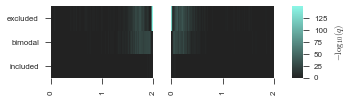

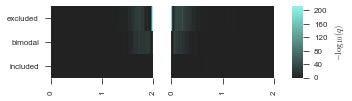

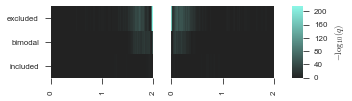

In [27]:
for phenotype, phenotype_df in modality_basewise_statistics.groupby('phenotype'):
    # PLot significance of basewise statistics
    figwidth = 2.5 * 2
    figheight = 0.3 * len(modality_basewise_statistics.groupby('modality').groups)

    fig, axes = plt.subplots(ncols=3, figsize=(figwidth, figheight), gridspec_kw=dict(width_ratios=[1, 1, 0.1]))
    cbar_ax = axes[-1]

    grouped = phenotype_df.groupby('intron')

    for intron, ax in zip(intron_order, axes):
        df = grouped.get_group(intron)
        basewise_statistics_2d = df.pivot(index='modality', columns='genome_direction_nt', values='$-\log_{10}(q)$')
        basewise_statistics_2d = basewise_statistics_2d.loc[MODALITY_ORDER[:3]].dropna()
        sns.heatmap(basewise_statistics_2d, cmap=cmap, ax=ax, vmin=0,
                    cbar_kws=dict(label='$-\log_{10}(q)$'), 
                    cbar_ax=cbar_ax)
        ax.set(ylabel='', xlabel='', xticks=[0, 200, 400])
        if not ax.is_first_col():
            ax.set(yticks=[], ylabel='')
        else:
            plt.setp(ax.get_yticklabels(), rotation=0)
    fig.subplots_adjust(wspace=0.01)
    fig.tight_layout()
    fig.savefig('{}/intron_basewise_conservation_statistics_{}_q_values.pdf'.format(figure_folder, phenotype))

In [28]:
# cmap = sns.light_palette((177, 66, 90), as_cmap=True, input='husl')
cmap = 'Greys'

In [29]:
import matplotlib as mpl

In [30]:
locator = mpl.ticker.MaxNLocator(4)

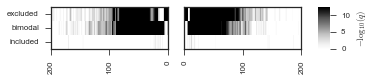

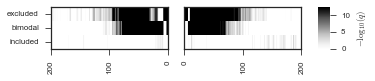

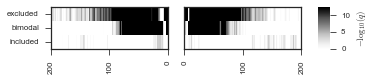

In [31]:
for phenotype, phenotype_df in modality_basewise_statistics.groupby('phenotype'):
    # PLot significance of basewise statistics
    figwidth = 2.5 * 2
    figheight = 0.15 * len(modality_basewise_statistics.groupby('modality').groups)

    fig, axes = plt.subplots(ncols=3, figsize=(figwidth, figheight), 
                             gridspec_kw=dict(width_ratios=[1, 1, 0.1], wspace=0.2))
    cbar_ax = axes[-1]

    grouped = phenotype_df.groupby('intron')

    for intron, ax in zip(intron_order, axes):
        df = grouped.get_group(intron)
        basewise_statistics_2d = df.pivot(index='modality', columns='genome_direction_nt', values='$-\log_{10}(q)$')
        basewise_statistics_2d = basewise_statistics_2d.loc[MODALITY_ORDER[:3]].dropna()
        sns.heatmap(basewise_statistics_2d, cmap=cmap, ax=ax, vmin=0, vmax=10,
                    cbar_kws=dict(label='$-\log_{10}(q)$'), 
                    cbar_ax=cbar_ax)
        ax.set(xticks=[])
        if not ax.is_first_col():
            ax.set(yticks=[], ylabel='', xlim=(0, 200), xlabel='',
                   xticklabels=[0, 100, 200], xticks=(0, 100, 200))
        else:
            plt.setp(ax.get_yticklabels(), rotation=0)
            xticklabels = ax.get_xticks()
            ax.set(xlim=(200, 400), xlabel='', xticklabels=[200, 100, 0], 
                   xticks=(200, 300, 400), ylabel='')
    cbar_ax.locator_params('y', nbins=4)
    cbar_ax.yaxis.set_ticklabels([0, 5, 10])
    fig.subplots_adjust(wspace=0.01)
    sns.despine(bottom=False, right=False, left=False, top=False)
#     fig.tight_layout()
    fig.savefig('{}/intron_basewise_conservation_statistics_{}_q_values_200nt.pdf'.format(figure_folder, phenotype))

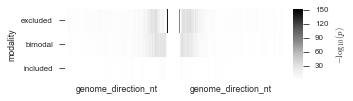

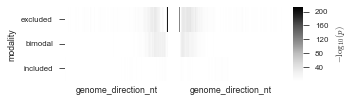

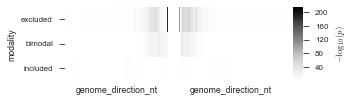

In [32]:
for phenotype, phenotype_df in modality_basewise_statistics.groupby('phenotype'):
    # PLot significance of basewise statistics
    figwidth = 2.5 * 2
    figheight = 0.3 * len(modality_basewise_statistics.groupby('modality').groups)

    fig, axes = plt.subplots(ncols=3, figsize=(figwidth, figheight), gridspec_kw=dict(width_ratios=[1, 1, 0.1]))
    cbar_ax = axes[-1]

    grouped = phenotype_df.groupby('intron')

    for intron, ax in zip(intron_order, axes):
        df = grouped.get_group(intron)
        basewise_statistics_2d = df.pivot(index='modality', columns='genome_direction_nt', values='$-\log_{10}(p)$')
        basewise_statistics_2d = basewise_statistics_2d.loc[MODALITY_ORDER[:3]].dropna()
        sns.heatmap(basewise_statistics_2d, cmap=cmap, ax=ax,
                    cbar_kws=dict(label='$-\log_{10}(p)$'), 
                    cbar_ax=cbar_ax)
        ax.set(xticks=[])
        if not ax.is_first_col():
            ax.set(yticks=[], ylabel='')
        else:
            plt.setp(ax.get_yticklabels(), rotation=0)
    fig.subplots_adjust(wspace=0.01)
    fig.tight_layout()
    fig.savefig('{}/intron_basewise_conservation_statistics_{}_p_values.pdf'.format(figure_folder, phenotype))